In [1]:
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from epam.torch_common import print_parameter_count

from netam import framework, models

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df, val_df = framework.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", val_nickname="51") #, sample_count=5000)

In [3]:
kmer_length = 5
max_length = 410

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 26592 training examples and 22424 validation examples


In [4]:
model = models.SHMoofModel(train_dataset)
print_parameter_count(model)
burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
#print("starting training...")
# losses = burrito.train(epochs=100)
# model.write_shmoof_output("_ignore/reshmoof")

kmer_embedding: 1025 parameters
log_site_rates: 410 parameters
-----
total: 1435 parameters


In [5]:
def set_requires_grad(model, attr_name, value):
    for param in getattr(model, attr_name).parameters():
        param.requires_grad = value

with torch.no_grad():
    model.log_site_rates.weight.data.zero_()

# Joint fitting is the original approach.
joint_fitting = False
epochs = 50

if joint_fitting:
    loss_history = burrito.train(epochs=epochs)

else:
    # First train the kmer embedding...
    set_requires_grad(model, 'kmer_embedding', True)
    set_requires_grad(model, 'log_site_rates', False)

    burrito.train(epochs=epochs)

    kmer_embedding_stored = model.kmer_embedding.weight.data.clone()

    # ...then train the log site rates, fixing the kmer embedding.
    burrito.reset_optimizer()
    # We get a slightly better fit by decreasing the learning rate.
    burrito.optimizer.param_groups[0]['lr'] = 0.01
    set_requires_grad(model, 'kmer_embedding', False)
    set_requires_grad(model, 'log_site_rates', True)

    loss_history = burrito.train(epochs=epochs)

    # Double check that the second round of training didn't change the kmer embedding
    assert torch.allclose(kmer_embedding_stored, model.kmer_embedding.weight.data)

loss_history.tail()

Epoch: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s, loss_diff=-2.49e-07, lr=0.01] 


,train_loss,val_loss
46,0.060411,0.060952
47,0.060410,0.060959
48,0.060413,0.060956
49,0.060412,0.060953
50,0.060410,0.060953


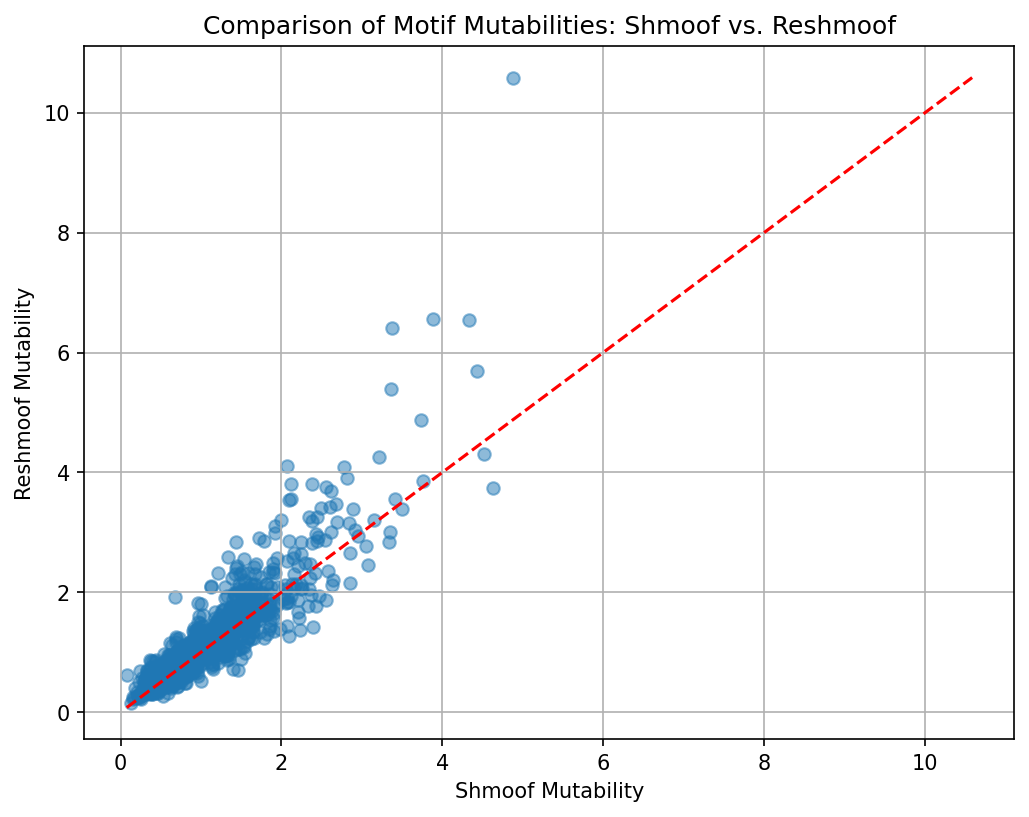

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
# reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')
reshmoof_mutabilities = torch.exp(model.kmer_embedding.weight).squeeze().detach().numpy()
reshmoof_motifs = pd.DataFrame({'Mutability': reshmoof_mutabilities, 'Motif': train_dataset.kmer_to_index.keys()})

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

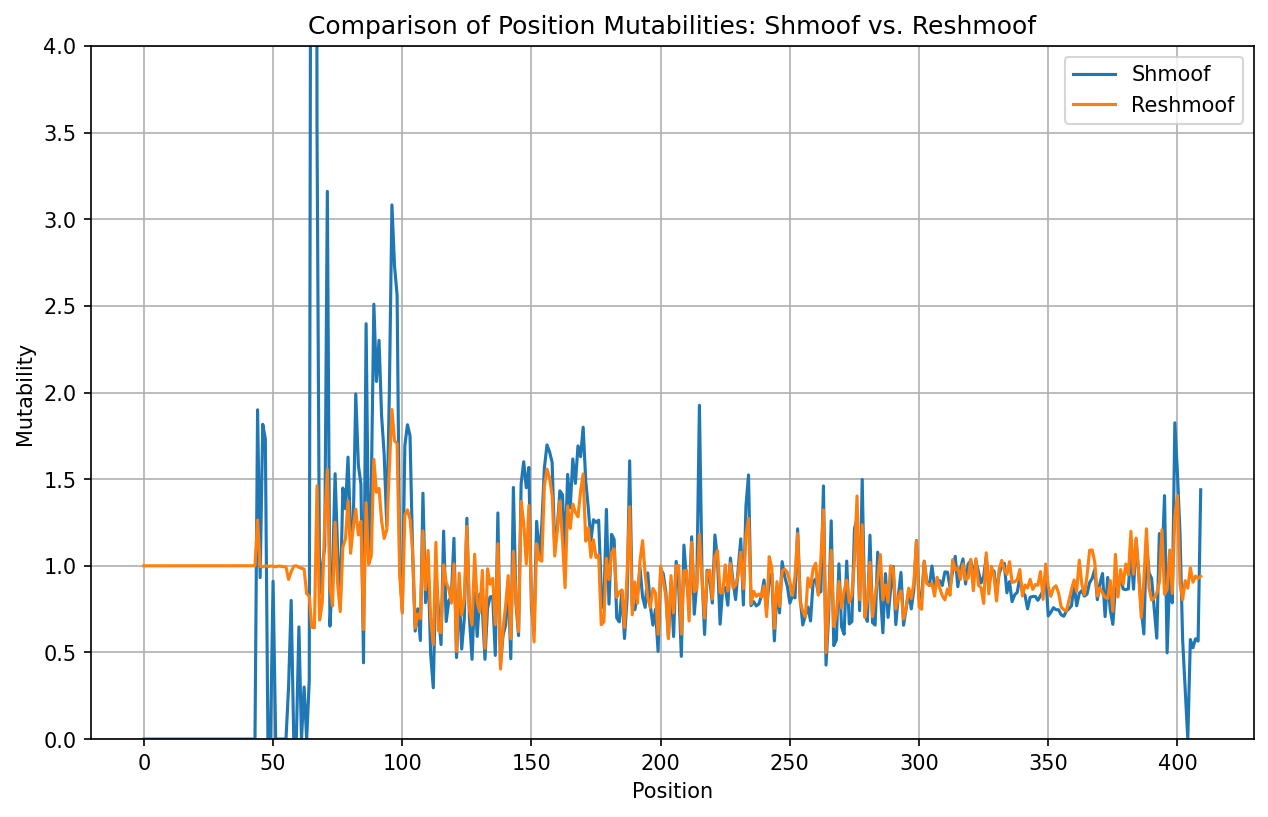

In [7]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
# Move to 0-indexing
shmoof_positions["Position"] -= 1
# reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')
reshmoof_positions = torch.exp(model.log_site_rates.weight).squeeze().detach().numpy()
reshmoof_positions = pd.DataFrame({'Position': np.arange(len(reshmoof_positions)), 'Mutability': reshmoof_positions})

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.ylim(0, 4)

plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()


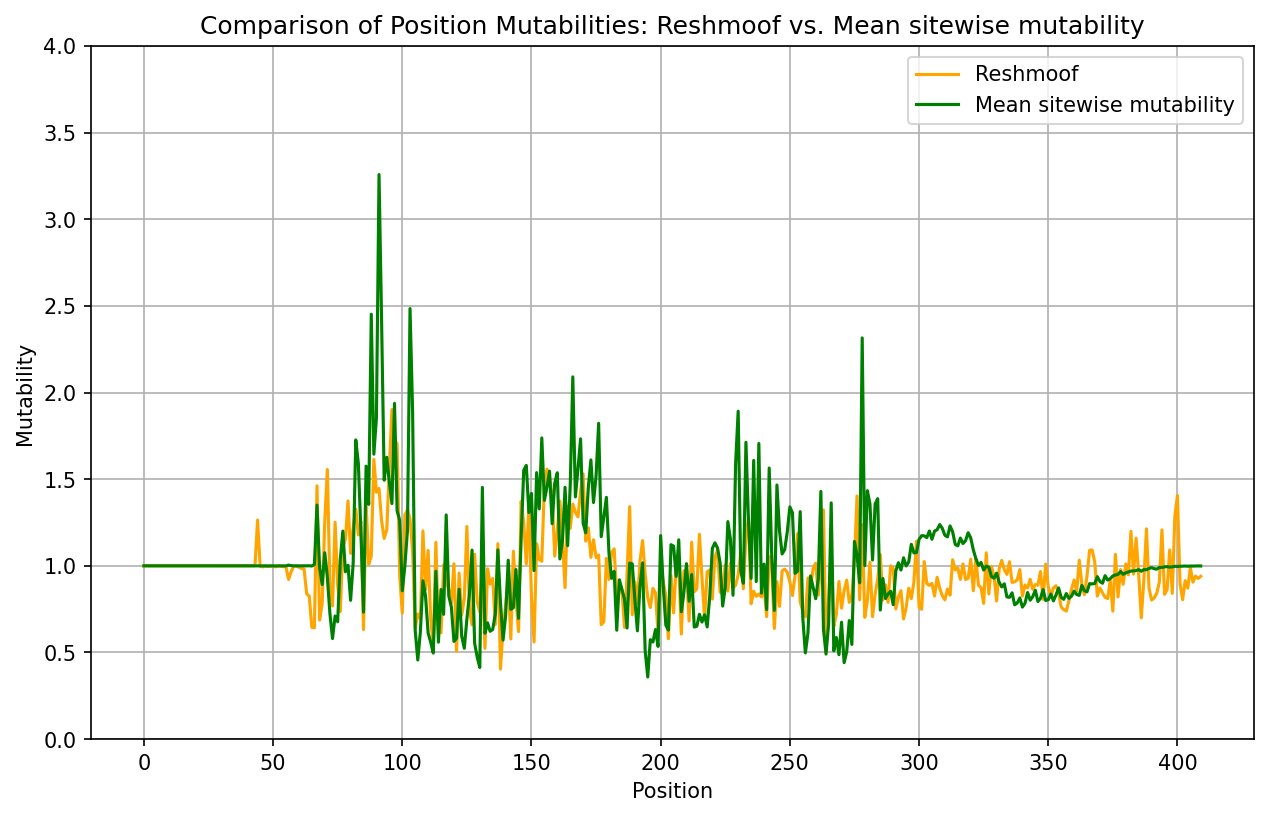

In [8]:
kmer_mutabilities = []

# turn reshmoof_motifs into a dict mapping "Motif" to "Mutability"
reshmoof_motifs_dict = dict(zip(reshmoof_motifs["Motif"], reshmoof_motifs["Mutability"]))

for parent in train_df["parent"]:
    kmer_mutability = np.ones(410)
    padded_parent = "NN" + parent + "NN"
    for i in range(min(410, len(padded_parent) - 5)):
        kmer_mutability[i] = reshmoof_motifs_dict.get(padded_parent[i:i+5], 1.0)
    kmer_mutabilities.append(kmer_mutability)

[kmer_mutability.shape for kmer_mutability in kmer_mutabilities]

mean_sitewise_mutability = np.stack(kmer_mutabilities).mean(axis=0)
mean_sitewise_mutability = pd.Series(mean_sitewise_mutability)

plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof', color='orange')
plt.plot(merged_positions['Position'], mean_sitewise_mutability, label='Mean sitewise mutability', color='green')
# plt.xlim(75, 200)
plt.ylim(0, 4)
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Reshmoof vs. Mean sitewise mutability')
plt.legend()
plt.grid(True)
plt.show()